<a href="https://colab.research.google.com/github/davidkubanek/Thesis/blob/main/concerto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONCERTO architecture

In [ ]:
# for running in colab
!pip install dgl
!pip install rdkit
!pip install torch_geometric
!pip install wandb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
if not torch.cuda.is_available():
  plt.rcParams["font.family"] = "Palatino"

import dgl
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader import DataLoader
#import wandb
import warnings

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

## Carci + Mut CONCERTO data
Load in the carcinogenecity and mutagenecity data as in CONCERTO paper.

In [ ]:
class CancerMutDatasetClass(Dataset):
	'''
	Imports and pre-processes the Cancer and Mutagenecity data and returns them in the form of a dataset
	'''
	def __init__(self, out_feats=1, drop_ionic=True, min_carbon_count=0, fraction_of_data=1, use_carc_prob=False, carc_percentile_to_drop=0):
		self.out_feats = out_feats
		self.drop_ionic = drop_ionic
		self.min_carbon_count = min_carbon_count
		self.fraction_of_data = fraction_of_data
		self.use_carc_prob = use_carc_prob
		self.carc_percentile_to_drop = carc_percentile_to_drop

	def load_carc_cpdb(cls):
		cpdb = pd.read_csv(
			'Data/concerto data/cpdb_aggergated.csv',
			usecols=['smiles', 'td50_log_harmonic', 'cas', 'carc_class', 'carc_class_multi']
		)
		cpdb['smiles'] = cls.smiles_standardize(cpdb['smiles'].values)
		cpdb = cpdb[cpdb['smiles'].notnull()]
		cpdb.rename(columns={'td50_log_harmonic': 'td50'}, inplace=True)
		assert cpdb['smiles'].duplicated().sum() == 0, \
			cpdb[cpdb['smiles'].duplicated(keep=False)].sort_values('smiles').to_string()
		cpdb['source'] = 'cpdb'
		return cpdb

	def load_mut_hansen(cls):
		ames_df = pd.read_csv('Data/concerto data/hansen_2009_ames.smi', sep='\t', names=['smiles', 'cas', 'class'])
		ames_df['smiles'] = cls.smiles_standardize(ames_df['smiles'].values)
		ames_df = ames_df[ames_df['smiles'].notnull()]
		ames_df.rename(columns={'class': 'mut_class'}, inplace=True)
		ames_df.drop(columns='cas', inplace=True)
		ames_df = ames_df[~ames_df.duplicated(['smiles', 'mut_class'])]
		assert ames_df['smiles'].duplicated().sum() == 0, \
			ames_df[ames_df['smiles'].duplicated(keep=False)].sort_values('smiles').to_string()
		ames_df['source'] = 'hansen'
		return ames_df


	def smiles_standardize(cls, smiles):
		new_smiles = []
		for smile in smiles:
			if pd.isnull(smile):
				new_smiles.append(None)
				continue
			# Generate the molecule from smile string
			mol = Chem.MolFromSmiles(smile)
			# If the smile string is null then continue
			if pd.isnull(mol):
				new_smiles.append(None)
			else:
				new_smiles.append(Chem.MolToSmiles(mol,canonical=True,isomericSmiles=False,allBondsExplicit=False))
		return new_smiles

	def count_num_carbons(cls, smile):
		mol = Chem.MolFromSmiles(smile)
		num_c = 0
		for atom in mol.GetAtoms():
			if atom.GetSymbol().upper() == 'C':
				num_c += 1
		return num_c

	def load_data(self):
		# Loaded data should not overlap mut_hansn and carc_cpdb since they are the two primary training data sources
		mut = self.load_mut_hansen()
		carc = self.load_carc_cpdb()

		carc_datasets = []
		mut_datasets = []

		carc_datasets.append(carc)

		# if 'carc_ccris' in self.carc_datasets:
		# 	temp = self.load_carc_ccris()
		# 	# drop samples that are in training data by default cpdb & carc_pred_el
		# 	temp = temp[~temp['smiles'].isin(carc['smiles'])]
		# 	carc_datasets.append(temp)

		mut_datasets.append(mut)

		if mut_datasets:
			mut = pd.concat(mut_datasets)
		else:
			mut = pd.DataFrame(columns=mut.columns)

		if carc_datasets:
			carc = pd.concat(carc_datasets)
		else:
			carc = pd.DataFrame(columns=carc.columns)

		# check for duplicates
		if mut['smiles'].duplicated().sum() != 0:
			warnings.warn(f"duplicated samples {mut['smiles'].duplicated().sum()} contained in mutagenicity data "
						  f"from {mut_datasets}\n"
						  f" {mut[mut['smiles'].duplicated(keep=False)].sort_values('smiles').head().to_string()}")
			mut.sort_values(['smiles', 'mut_class'], ascending=False)
			mut = mut[~mut.duplicated('smiles')]

		if carc['smiles'].duplicated().sum() != 0:
			warnings.warn(f"duplicated samples {carc['smiles'].duplicated().sum()} contained in carcinogenicity data "
						  f"from {carc_datasets}\n"
						  f" {carc[carc['smiles'].duplicated(keep=False)].sort_values('smiles').head().to_string()}")
			carc = carc[~carc.duplicated('smiles')]

		# merge the mut and carc datasets
		df = pd.merge(mut, carc, how='outer', on='smiles')
		df['source'] = df['source_x'].fillna('') + ',' + df['source_y'].fillna('')
		df.drop(columns=['source_x', 'source_y'], inplace=True)

		required_columns = ['td50', 'carc_class', 'mut_class', 'carc_class_multi']
		for column in required_columns:
			if column not in df.columns:
				df[column] = np.nan

		if self.drop_ionic:
			df = df[~df['smiles'].str.contains('\.')]

		df['carbon_count'] = [self.count_num_carbons(x) for x in df['smiles'].values]
		if self.min_carbon_count:
			df = df[df['carbon_count'] >= self.min_carbon_count]

		# Shuffle the data
		index = np.arange(len(df))
		np.random.seed(1337)
		np.random.shuffle(index)
		df = df.iloc[index].reset_index(drop=True)

		# Log of Betas that were fitted using a cox regression model
		if self.carc_percentile_to_drop > 0:
			# cleave off the top percentile
			lowest_td_50_val = np.nanpercentile(df['td50'].values, self.carc_percentile_to_drop)
			mask = df[df['td50'] <= lowest_td_50_val].index
			df.loc[mask, 'td50'] = lowest_td_50_val

		betas = np.log((np.log(2) / df["td50"].values))

		# standardize
		beta_standardized = (betas - np.nanmean(betas)) / np.nanstd(betas)
		# normalize
		beta_normalized = betas - np.nanmin(betas)
		beta_normalized = beta_normalized / np.nanmax(beta_normalized)

		df['beta_standardized'] = beta_standardized
		df['beta_normalized'] = beta_normalized

		if self.fraction_of_data < 1:
			new_data_len = int(len(df) * self.fraction_of_data)
			df = df.iloc[:new_data_len]

		#save the resulting dataframe
		self.df = df


In [ ]:
dataset = CancerMutDatasetClass()
dataset.load_data()

In [ ]:
# give random draw of data
dataset.df.sample(10)

,smiles,mut_class,cas,td50,carc_class_multi,carc_class,source,carbon_count,beta_standardized,beta_normalized
1633,CC(C)(C)c1ccc(OP2OCC3(CO2)COP(Oc2ccc(C(C)(C)C)...,0.0,NaN,NaN,NaN,NaN,"hansen,",33,NaN,NaN
4820,Nc1ccc(CO)c([N+](=O)[O-])c1,1.0,NaN,NaN,NaN,NaN,"hansen,",7,NaN,NaN
6547,NCCNCCNCCN,1.0,NaN,NaN,NaN,NaN,"hansen,",6,NaN,NaN
1001,BrCc1c2ccccc2c2ccc3cccc4ccc1c2c43,1.0,NaN,NaN,NaN,NaN,"hansen,",21,NaN,NaN
545,OC1C=Cc2ncccc2C1O,0.0,NaN,NaN,NaN,NaN,"hansen,",9,NaN,NaN
4971,COC(C(=O)O)c1ccccc1,NaN,1701-77-5,6.598778,2.0,1.0,",cpdb",9,-0.085314,0.175281
1094,CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C,0.0,NaN,NaN,NaN,NaN,"hansen,",23,NaN,NaN
1664,CC(=O)Nc1nc2c3cccnc3ccc2n1C,1.0,NaN,NaN,NaN,NaN,"hansen,",13,NaN,NaN
5062,O=[N+]([O-])c1ccc2c3ccccc3c3cccc4ccc1c2c43,1.0,NaN,NaN,NaN,NaN,"hansen,",20,NaN,NaN
1571,CN(C)c1nc(N(C)C)nc(N(C)C)n1,0.0,NaN,NaN,NaN,NaN,"hansen,",9,NaN,NaN


In [ ]:
'''
Some things from the original code that I might need to use later
'''
# Clip loss
# torch.nn.utils.clip_grad_norm_(model.parameters(), args["gradient_clip_norm"])
# optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['network_weight_decay'])
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=args['lr_decay_factor'])

# early_stop = stopper.step(val_score, model)
# if args["use_wandb"]:
#     wandb.log({
#         f"epoch{note}": epoch + 1,
#         f"training_carcinogenic_loss{note}": train_carc_loss,
#         f"training_mutagenic_loss{note}": train_mut_loss,
#         f"training_loss{note}": train_loss,
#         f"training_mut_{train_mut_metric_name}{note}": train_mut_metric,
#         f"training_mut_{train_mut_metric_name2}{note}": train_mut_metric2,
#         f"training_carc_{train_carc_metric_name}{note}": train_carc_metric,
#         f"training_carc_{train_carc_metric_name2}{note}": train_carc_metric2,

#         f"validation_loss{note}": val_loss,
#         f"validation_carc_loss{note}": val_carc_loss,
#         f"validation_mut_loss{note}": val_mut_loss,
#         f"validation_carc_{val_carc_metric_name}{note}": val_carc_metric,
#         f"validation_carc_{val_carc_metric_name2}{note}": val_carc_metric2,
#         f"validation_mut_{val_mut_metric_name}{note}": val_mut_metric,
#         f"validation_mut_{val_mut_metric_name2}{note}": val_mut_metric2,
#     })

# if early_stop:
#     break
# stopper.load_checkpoint(model)


## HTSFP PubChem data
Load in the HTSFP data from the activity matrix generated in 'HTS_fingerprints'

In [9]:
# Load the matrix
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/'
else:
    directory = '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Data'

matrix_df = pd.read_csv(directory+'/final/activity_matrix_579_median_binary_at2.csv') #Thesis/Data

# shuffle dataframe (otherwise some assays sorted acsendingly)
def shuffle_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    return df
matrix_df = shuffle_df(matrix_df)

print('Binary activity matrix shape: ', matrix_df.shape)
matrix_df.head()

Binary activity matrix shape:  (324192, 272)


,SMILES,602399,588352,720702,624377,602429,588621,720700,720648,624416,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,C1CN(CCC1C(=O)N)C2=C(N=C(O2)C3=CC=CS3)S(=O)(=O...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C1CCC(CC1)C(=O)N2CCC3=CC=CC=C3C2CN4C(=O)C5=CC=...,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,CCOC(=O)C1CCN(CC1)C(=O)CCCCN2C(=O)C3=CC=CC=C3N...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1CCC(C1)N2C(=NN=N2)C(C3=CC=CS3)N4CCN(CC4)C5=C...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C[C@@]1([C@@H]2[C@H]([C@H](N1)C3=CC=C(C=C3)C4=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


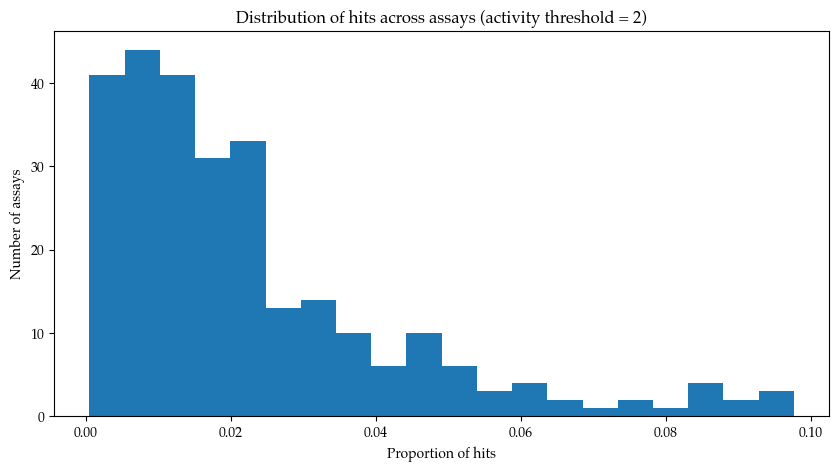

Assays with few hits (<1%): 
 # 84 
 ['720702' '624377' '588621' '624038' '651560' '651602' '504651' '624267'
 '651957' '624304' '651572' '602244' '602250' '686964' '624040' '651800'
 '624125' '602123' '588664' '624126' '624169' '720509' '652017' '743269'
 '651718' '602141' '2380' '2550' '2642' '2648' '2825' '435030' '449728'
 '463079' '463141' '463210' '485347' '488965' '488975' '488977' '489030'
 '489031' '492972' '493008' '493087' '493098' '493160' '493187' '493244'
 '504406' '504523' '504577' '504621' '504634' '504692' '504734' '540267'
 '540295' '588335' '588627' '588675' '588676' '588819' '602410' '623877'
 '1511' '1554' '1875' '1950' '1987' '2234' '2300' '2445' '2553' '2690'
 '434962' '434989' '463111' '463165' '463190' '463212' '485272' '651719'
 '588511']


In [19]:
# sum matrix_df across rows, excluding the first column 'SMILES'
hit_ratio = matrix_df.iloc[:,1:].sum(axis=0)/matrix_df.shape[0]

#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(hit_ratio, bins=20)
plt.xlabel('Proportion of hits')
plt.ylabel('Number of assays')
plt.title(f'Distribution of hits across assays (activity threshold = 2)')
plt.show()

print('Assays with few hits (<1%): \n #', len(matrix_df.columns[1:][torch.where(torch.tensor(hit_ratio)<0.01)].values), '\n', matrix_df.columns[1:][torch.where(torch.tensor(hit_ratio)<0.01)].values)

### Split assays into types: cell-based, biochemical & high, medium and low hit-rate

In [55]:
# load list of cell-based assays
with open(directory + '/info/cell_based_assays.txt', 'r') as file:
    lines = file.read().splitlines()
cell_based = list(map(str, lines))

# load list of biochemical non-cell-based assays
with open(directory + '/info/non_cell_based_assays.txt', 'r') as file:
    lines = file.read().splitlines()
non_cell_based = list(map(str, lines))

# separate the items into low, medium, and high hit rate items
low_hit_rate = matrix_df.columns[1:][torch.where(torch.tensor(hit_ratio)<0.01)].values 
high_hit_rate = matrix_df.columns[1:][torch.where(torch.tensor(hit_ratio)>=0.05)].values
# the rest of the items are medium hit rate items
med_hit_rate = list(set(list(matrix_df.columns[1:])) - set(list(low_hit_rate)) - set(list(high_hit_rate)))

print('Sizes of hit rate categories (low, med, high, all):', len(low_hit_rate), len(medium_hit_rate), len(high_hit_rate), len(hit_ratio))
print('\n')

# separating cell-based and non-cell-based into categories based on hit rate
cell_based_high_hr =list(set(cell_based).intersection(set(high_hit_rate)))
cell_based_med_hr = list(set(cell_based).intersection(set(med_hit_rate)))
cell_based_low_hr = list(set(cell_based).intersection(set(low_hit_rate)))
print('Cell based category sizes (low, med, high):',len(cell_based_low_hr), len(cell_based_med_hr), len(cell_based_high_hr))
non_cell_based_high_hr = list(set(non_cell_based).intersection(set(high_hit_rate)))
non_cell_based_med_hr = list(set(non_cell_based).intersection(set(med_hit_rate)))
non_cell_based_low_hr = list(set(non_cell_based).intersection(set(low_hit_rate)))
print('Non-cell based category sizes (low, med, high):',len(non_cell_based_low_hr), len(non_cell_based_med_hr), len(non_cell_based_high_hr))


Sizes of hit rate categories (low, med, high, all): 84 162 25 271


Cell based category sizes (low, med, high): 37 38 7
Non-cell based category sizes (low, med, high): 47 124 18


In [53]:
cell_based_high_hr

['743397', '602248', '2796', '2797', '1910', '1979', '624127']

# Representation

## Fingerprints
smiles →  fingerprints

In [56]:
def convert_smile_to_fp_bit_string(smile):
        """
        Convert SMILES string to concatenation of RDFKIT, Morgan and MACCSS fingerprints.
        """
        # RDFKIT (fingerprint dim fpSize=1024)
        x = Chem.MolFromSmiles(smile)
        fp1 = Chem.RDKFingerprint(x, fpSize=1024)

        # MACCSS substructure (fingerprint dim 167)
        fp2 = MACCSkeys.GenMACCSKeys(x)

        # Morgan (fingerprint dim fpSize=1024)
        fp_hashes = []
        fp3 = AllChem.GetHashedMorganFingerprint(x, 2, nBits=1024)
        fp3_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp3, fp3_array)
        fp_hashes.append(fp3_array)

        # combine all fingerprints
        fp = fp1.ToBitString() + fp2.ToBitString()
        fp = np.array(list(fp)).astype(np.int8)
        fp = np.concatenate([fp] + fp_hashes)
        fp = torch.tensor(fp).to(torch.float32)
        return fp

Get sample fingerprint

SMILES: CC1=CC=NC2=NC(=NN12)C(=O)NC3=NC4=CC=CC=C4S3
Fingerprint: tensor([1., 0., 1.,  ..., 0., 0., 0.]) torch.Size([2215])
RDK Fingerprint:


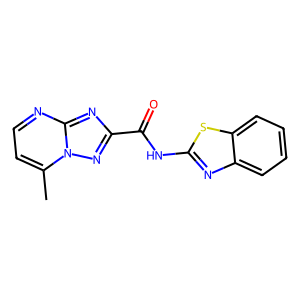

In [57]:
smile = matrix_df.sample(1)['SMILES'].item()
fp = convert_smile_to_fp_bit_string(smile)
print('SMILES:', smile)
print('Fingerprint:', fp, fp.shape)

x = Chem.MolFromSmiles(smile)
fp1 = Chem.RDKFingerprint(x, fpSize=1024)
fp1 = np.array(list(fp1.ToBitString())).astype(np.int8)
from rdkit.Chem import Draw
img = Draw.MolToImage(x)
print('RDK Fingerprint:')
img

## Graph embedding
smiles →  graph embedding

In [8]:
# smiles to graphs
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

class GraphDatasetClass:
    '''
    Convert a dataframe of SMILES into a Pytorch Geometric Graph Dataset.
    https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
    '''

    def __init__(self):
        pass

    def one_hot_encoding(self, x, permitted_list):
        """
        Maps input elements x which are not in the permitted list to the last element
        of the permitted list.
        """

        if x not in permitted_list:
            x = permitted_list[-1]

        binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

        return binary_encoding


    def get_atom_features(self, atom,
                        use_chirality = True,
                        hydrogens_implicit = True):
        """
        Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
        """

        # define list of permitted atoms

        permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

        if hydrogens_implicit == False:
            permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

        # compute atom features

        atom_type_enc = self.one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

        n_heavy_neighbors_enc = self.one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

        formal_charge_enc = self.one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

        hybridisation_type_enc = self.one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

        is_in_a_ring_enc = [int(atom.IsInRing())]

        is_aromatic_enc = [int(atom.GetIsAromatic())]

        atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

        vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

        covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

        atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

        if use_chirality == True:
            chirality_type_enc = self.one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
            atom_feature_vector += chirality_type_enc

        if hydrogens_implicit == True:
            n_hydrogens_enc = self.one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
            atom_feature_vector += n_hydrogens_enc

        return np.array(atom_feature_vector)

    def get_bond_features(self, bond,
                        use_stereochemistry = True):
        """
        Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
        """

        permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

        bond_type_enc = self.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

        bond_is_conj_enc = [int(bond.GetIsConjugated())]

        bond_is_in_ring_enc = [int(bond.IsInRing())]

        bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

        if use_stereochemistry == True:
            stereo_type_enc = self.one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
            bond_feature_vector += stereo_type_enc

        return np.array(bond_feature_vector)

    def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(self, x_smiles, y):
        """
        Inputs:

        x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
        y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

        Outputs:

        data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

        """

        data_list = []

        for (smiles, y_val) in zip(x_smiles, y):

            # convert SMILES to RDKit mol object
            mol = Chem.MolFromSmiles(smiles)

            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(self.get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(self.get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = self.get_atom_features(atom)

            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)

            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))

            for (k, (i,j)) in enumerate(zip(rows, cols)):

                EF[k] = self.get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

            EF = torch.tensor(EF, dtype = torch.float)

            # construct label tensor
            y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)

            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

        return data_list

## GROVER: graph transformer  fingerprints
smiles → node/edge features using RDkit → to fingerprint embedding using GTransformer

In [72]:
# import fingerprint .np file
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/'
else:
    directory = '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Data' #'Data/'

grover_fp = np.load(directory + '/final/fp_large.npz', allow_pickle=True)
print(grover_fp.keys())  # Display the keys or attributes in the file
# Access and examine the data as needed
assert len(matrix_df)==len(grover_fp['smiles']), f'SMILES mismatch: {len(matrix_df)} and {len(grover_fp)} are not equal'

Index(['smiles', 'fps'], dtype='object')


In [74]:
grover_fp['smiles']

0         CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...
1         CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...
2                    CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C
3                               C1=CC=C2C(=C1)C=C(C(=O)O2)N
4         C1COCCN1S(=O)(=O)C2=C(C=CC(=C2)C(=O)NC3=CC4=C(...
                                ...                        
324187    C1CC(C1)C(=O)N2CCC3=C2C=CC(=C3)S(=O)(=O)N4CCC5...
324188    CCOC(=O)C1=C(N(N=C1)C2=NC=NC3=C2C=NN3CC4=CC=CC...
324189                          CN1CCN(CC1)CC(C2=CC=CC=C2)O
324190    CCCC1=NC2=C(C(=C(S2)C)C)C(=N1)SCC(=O)N3CCC4=CC...
324191    CC1=CC2=NC3=C(C=C2C=C1)C(=C(S3)C(=O)N4CC(=O)NC...
Name: smiles, Length: 324192, dtype: object

In [75]:
grover_fp['fps'][0].shape[0]

5000

In [229]:
args = {}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data parameters
args['num_data_points'] = 324191 # number of data points to use
args['assay_list'] = cell_based_high_hr #for all: matrix_df.columns.values[1:]
args['num_assays'] = 5 # number of assays to use (i.e., no. of output classes)
args['assay_start'] = 0 # which assay to start from

args['num_node_features'] = 79 # number of node features in graph representation
args['grover_fp_dim'] = grover_fp['fps'][0].shape[0] # None  # dim of grover fingerprints
args['fp_dim'] = 2215 # dim of fingerprints


# training parameters
args['model'] = 'GCN' # 'GCN', 'GCN_FP', 'FP', 'GROVER', 'GROVER_FP'
args['pred_type'] = 'classification' # 'regression', 'classification'
args['num_layers'] = 5 # number of layers in MLP
args['hidden_channels'] = 64
args['dropout'] = 0.1
args['batch_size'] = 64
args['num_epochs'] = 100
args['lr'] = 0.01
#args['gradient_clip_norm'] = 1.0
#args['network_weight_decay'] = 0.0001
#args['lr_decay_factor'] = 0.5

# check batch size -> to include examples of classes
# dropout maybe higher





In [ ]:
from sklearn.model_selection import train_test_split

# X: Features, y: Binary label vectors (multi-class binary labels)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
#from skmultilearn.model_selection import MultiLabelStratifiedKFold
import skmultilearn.model_selection as skms
# Create an instance of MultiLabelStratifiedKFold with the desired number of folds
n_folds = 1  # Number of folds for cross-validation
mlskf = MultiLabelStratifiedKFold(n_splits=n_folds, random_state=42)

# Loop through each fold and split the data into train and test sets
for train_idx, test_idx in mlskf.split(data, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [237]:
from torch_geometric.loader import DataLoader

def prepare_dataset(matrix_df, args, grover_fp=None):
    '''
    Convert matrix dataframe to a dataloader with pytorch geometric graph data, fingerprints and labels.
    Inputs:
        matrix_df: dataframe of SMILES, assays and bioactivity labels
        args: arguments
    Outputs:
        dataloader: dictionary of dataloaders for train and test
    '''
    # only use subset of data (assays and data points)
    assay_list = args['assay_list']
    num_assays = args['num_assays']
    assay_start = args['assay_start']
    num_data_points = args['num_data_points']

    # get binary target labels
    y = matrix_df[assay_list[assay_start:assay_start+num_assays]].values[:num_data_points]

    # get SMILES strings
    data = matrix_df['SMILES'].values[:num_data_points]


    GraphDataset = GraphDatasetClass()
    # create pytorch geometric graph data list
    data_list = GraphDataset.create_pytorch_geometric_graph_data_list_from_smiles_and_labels(data, y)

    # add fingerprint data to each graph
    for i, smile in enumerate(data):
        fp = convert_smile_to_fp_bit_string(smile)
        data_list[i].fp = fp


    # add grover fingerprint to each graph
    if grover_fp is not None:
        for i, gfp in enumerate(grover_fp['fps'][:args['num_data_points']]):
          data_list[i].grover_fp = torch.tensor(gfp)


    # split into train and test
    train_dataset = data_list[:int(len(data)*0.8)]
    test_dataset = data_list[int(len(data)*0.8):]

    # split into train and validation
    val_dataset = train_dataset[:int(len(train_dataset)*0.25)]
    train_dataset = train_dataset[int(len(train_dataset)*0.25):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')
    print(f'Number of test graphs: {len(test_dataset)}')
    print(f'Example of a graph data object: {data_list[0]}')

    # create data loaders
    dataloader = {}
    dataloader['train'] = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
    dataloader['val'] = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
    dataloader['test'] = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

    return dataloader

def analyze_dataset(dataset, args):
    '''
    Analyze the distribution of positive classes in the dataset
    '''
    positive = []
    for i in range(len(dataset)):
        positive.append(dataset[i].y[0].sum().item())


    num_assays = args['num_assays']
    # make histogram of the number of positive
    plt.figure(figsize=(7, 4))
    # define bins
    bins = np.linspace(0, num_assays, num_assays+1)-0.5
    plt.hist(positive, bins=bins, alpha=0.5, label='train')
    num_assays = args['num_assays']
    plt.xlabel(f'# of positive hits in target vector (out of {num_assays})')
    plt.ylabel('Number of data points')
    plt.title('Histogram of positive class distribution')
    plt.show()

    for i in range(num_assays+1):
        print(f'Number of data points with {i} positive targets: ', (np.array(positive) == i).sum(), f'({(np.array(positive) == i).sum()/len(positive)*100:.2f}%)')

def data_explore(dataloader):
    '''
    Explore the data
    '''
    # check proportion of positive and negative samples across each assay
    pos = torch.zeros(args['num_assays'])
    for data in dataloader:  # Iterate in batches over the training dataset
        # print('inputs:')
        # print(' x:', data.x.shape, '| y:',data.y.shape, '| fp:',data.fp.shape, '| grover:', data.grover_fp.shape)
        pos += data.y.sum(axis=0)
        #  print(data.y.sum(axis=0))
    print('# positive samples:', pos)
    print(torch.round((pos/len(dataloader.dataset)*100),decimals=2),'% are positive')


In [231]:
dataloader = prepare_dataset(matrix_df, args, grover_fp=grover_fp)

[12:26:22] WARNING: not removing hydrogen atom without neighbors
[12:31:23] WARNING: not removing hydrogen atom without neighbors
[12:40:53] WARNING: not removing hydrogen atom without neighbors
[12:44:33] WARNING: not removing hydrogen atom without neighbors


Number of training graphs: 194514
Number of validation graphs: 64838
Number of test graphs: 64839
Example of a graph data object: Data(x=[29, 79], edge_index=[2, 64], edge_attr=[64, 10], y=[1, 5], fp=[2215], grover_fp=[5000])



-------------------Train set-------------------


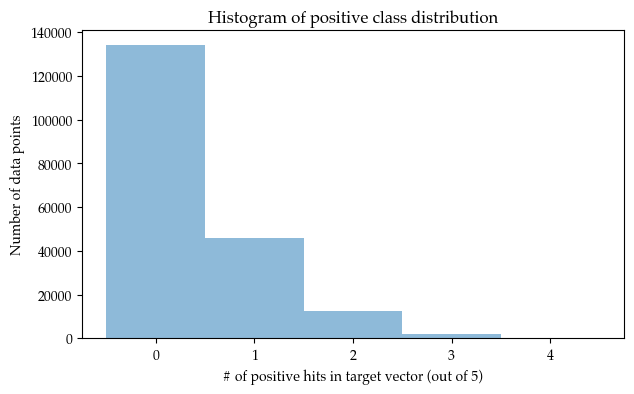

Number of data points with 0 positive targets:  134210 (69.00%)
Number of data points with 1 positive targets:  45860 (23.58%)
Number of data points with 2 positive targets:  12329 (6.34%)
Number of data points with 3 positive targets:  1922 (0.99%)
Number of data points with 4 positive targets:  187 (0.10%)
Number of data points with 5 positive targets:  6 (0.00%)

-------------------Val set-------------------


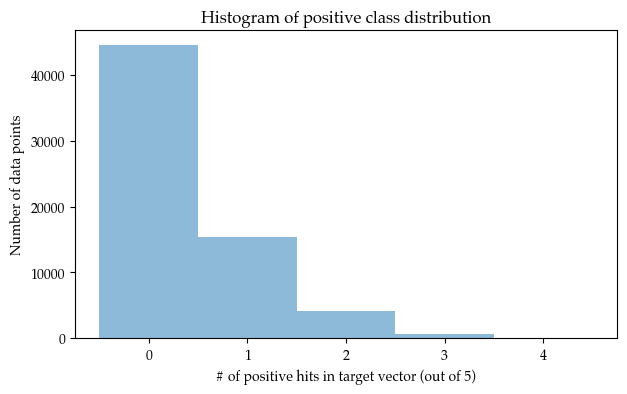

Number of data points with 0 positive targets:  44560 (68.73%)
Number of data points with 1 positive targets:  15367 (23.70%)
Number of data points with 2 positive targets:  4187 (6.46%)
Number of data points with 3 positive targets:  649 (1.00%)
Number of data points with 4 positive targets:  73 (0.11%)
Number of data points with 5 positive targets:  2 (0.00%)

-------------------Test set-------------------


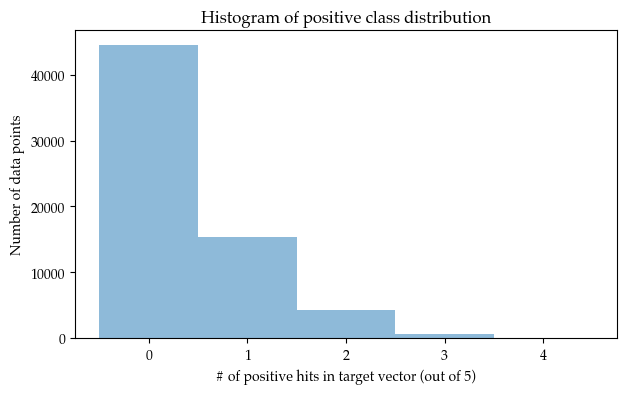

Number of data points with 0 positive targets:  44519 (68.66%)
Number of data points with 1 positive targets:  15383 (23.72%)
Number of data points with 2 positive targets:  4221 (6.51%)
Number of data points with 3 positive targets:  643 (0.99%)
Number of data points with 4 positive targets:  67 (0.10%)
Number of data points with 5 positive targets:  6 (0.01%)


In [232]:
print('\n-------------------Train set-------------------')
analyze_dataset(dataloader['train'].dataset, args)
print('\n-------------------Val set-------------------')
analyze_dataset(dataloader['val'].dataset, args)
print('\n-------------------Test set-------------------')
analyze_dataset(dataloader['test'].dataset, args)

In [238]:
data_explore(dataloader['train'])

# positive samples: tensor([16822., 16636., 18488., 10730., 14386.])
tensor([8.6500, 8.5500, 9.5000, 5.5200, 7.4000]) % are positive


In [239]:
data_explore(dataloader['test'])

# positive samples: tensor([5644., 5632., 6361., 3597., 4818.])
tensor([8.7000, 8.6900, 9.8100, 5.5500, 7.4300]) % are positive


# Models
### GCN and GCN_FP
- GCN: graph embedding followed by a final classification layer
- GCN_FP: graph + fingerprints embedding followed by a final classification layer

In [179]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    '''
    Define a Graph Convolutional Network (GCN) model architecture.
    Can include 'graph' only or 'graph + fingerprints' embedding before final classification layer.
    '''
    def __init__(self, args):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        num_node_features = args['num_node_features']
        hidden_channels = args['hidden_channels']
        num_classes = args['num_assays']
        if args['model'] == 'GCN_FP':
            fp_dim = args['fp_dim']
        else:
            fp_dim = 0

        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels + fp_dim, num_classes)

    def forward(self, x, edge_index, batch, fp=None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # if also using fingerprints
        if fp is not None:
            # reshape fp to batch_size x fp_dim
            fp = fp.reshape(x.shape[0], -1)
            # concatenate graph node embeddings with fingerprint
            # print('BEFORE CONCAT x:',x.shape, 'fp:', fp.shape)
            x = torch.cat([x, fp], dim=1)
            # print('AFTER CONCAT x:',x.shape)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)

        return x


In [180]:
# TEST that GCN runs for all model types
print('TESTING')
for model_type in ['GCN','GCN_FP']:
  args['model'] = model_type
  model = GCN(args)
  for data in dataloader['train']:  # Iterate in batches over the training dataset
          print(f'------{model_type}------')
          print('inputs:')
          print(' x:', data.x.shape, '| y:',data.y.shape, '| fp:',data.fp.shape, '| grover:', data.grover_fp.shape)
          if args['model'] == 'GCN': # Perform a single forward pass
              out = model(data.x, data.edge_index, data.batch)
          elif args['model'] == 'GCN_FP':
              out = model(data.x, data.edge_index, data.batch, fp=data.fp)
          print('out:',out.shape)
          print('gt:', data.y.shape)
          break

TESTING
------GCN------
inputs:
 x: torch.Size([1593, 79]) | y: torch.Size([64, 5]) | fp: torch.Size([141760]) | grover: torch.Size([320000])
out: torch.Size([64, 5])
gt: torch.Size([64, 5])
------GCN_FP------
inputs:
 x: torch.Size([1624, 79]) | y: torch.Size([64, 5]) | fp: torch.Size([141760]) | grover: torch.Size([320000])
out: torch.Size([64, 5])
gt: torch.Size([64, 5])


### FP, GROVER and GROVER_FP
- FP: fingerprints embedding followed by a final classification layer
- GROVER: graph transformer embedding followed by a final classification layer
- GROVER_FP: graph transformer + fingerprints embedding followed by a final classification layer

In [181]:

class LinearBlock(nn.Module):
	""" basic block in an MLP, with dropout and batch norm """

	def __init__(self, in_feats, out_feats, dropout=0.1):
		super(LinearBlock, self).__init__()
		self.linear = nn.Linear(in_feats, out_feats)
		self.bn = nn.BatchNorm1d(out_feats)
		self.dropout = nn.Dropout(dropout)

	def forward(self, x):
		# ReLU activation, batch norm, dropout on layer
		return self.bn(self.dropout(F.relu(self.linear(x))))

def construct_mlp(in_dim, out_dim, hidden_dim, hidden_layers, dropout=0.1):
	"""
	Constructs an MLP with specified dimensions.
		- total number of layers = hidden_layers + 1 (the + 1 is for the output linear)
		- no activation/batch norm/dropout on output layer
	"""

	assert hidden_layers >= 1, hidden_layers
	mlp_list = []
	mlp_list.append(LinearBlock(in_dim,hidden_dim,dropout=dropout))
	for i in range(hidden_layers-1):
		mlp_list.append(LinearBlock(hidden_dim,hidden_dim,dropout=dropout))

	# no activation/batch norm/dropout on output layer
	mlp_list.append(nn.Linear(hidden_dim,out_dim))
	mlp = nn.Sequential(*mlp_list)
	return mlp

class MLP(nn.Module):
	'''
	MLP with optional Grover fingerprints.
	Customizable number of layers, hidden dimensions, and dropout.
	'''
	def __init__(self, args):

		super(MLP, self).__init__()

		self.model_type = args['model']
		self.fp_dim = args['fp_dim'] # can be 0
		self.grover_fp_dim = args['grover_fp_dim'] # can be 0
		self.hidden_dim = args['hidden_channels']
		self.output_dim = args['num_assays']
		self.num_layers = args['num_layers']
		self.dropout = args['dropout']

		assert self.model_type in ['FP','GROVER','GROVER_FP'], f'model type not supported: {self.model_type}'

		if self.model_type == 'FP':
			self.grover_fp_dim = 0
		elif self.model_type == 'GROVER':
			self.fp_dim = 0

		self.ff_layers = construct_mlp(
			self.fp_dim + self.grover_fp_dim,
			self.output_dim,
			self.hidden_dim,
			self.num_layers,
			self.dropout
		)

	def forward(self, data):


		if self.model_type == 'FP': # only fp is used
			fingerprints = data.fp
			# reshape fp to batch_size x fp_dim
			fingerprints = fingerprints.reshape(int(fingerprints.shape[0]/self.fp_dim), -1)

			output = self.ff_layers(fingerprints)

		elif self.model_type == 'GROVER': # only grover is used
			# reshape grover_fp to batch_size x grover_fp_dim
			grover_fp = data.grover_fp
			grover_fp = grover_fp.reshape(int(grover_fp.shape[0]/self.grover_fp_dim), -1)

			output = self.ff_layers(grover_fp)

		elif self.model_type == 'GROVER_FP': #grover and fp are concatenated
			fingerprints = data.fp
			# reshape fp to batch_size x fp_dim
			fingerprints = fingerprints.reshape(int(fingerprints.shape[0]/self.fp_dim), -1)
			# reshape grover_fp to batch_size x grover_fp_dim
			grover_fp = data.grover_fp
			grover_fp = grover_fp.reshape(int(grover_fp.shape[0]/self.grover_fp_dim), -1)

			output = self.ff_layers(torch.cat([fingerprints, grover_fp], dim=1))


		return output

In [182]:
# TEST that MLP runs for all model types
print('TESTING')
for model_type in ['FP','GROVER','GROVER_FP']:
  args['model'] = model_type
  model = MLP(args)
  for data in dataloader['train']:  # Iterate in batches over the training dataset
          print(f'------{model_type}------')
          print('inputs:')
          print(' x:', data.x.shape, '| y:',data.y.shape, '| fp:',data.fp.shape, '| grover:', data.grover_fp.shape)
          out = model(data)  # Perform a single forward pass
          print('out:',out.shape)
          print('gt:', data.y.shape)
          break

TESTING
------FP------
inputs:
 x: torch.Size([1604, 79]) | y: torch.Size([64, 5]) | fp: torch.Size([141760]) | grover: torch.Size([320000])
out: torch.Size([64, 5])
gt: torch.Size([64, 5])
------GROVER------
inputs:
 x: torch.Size([1620, 79]) | y: torch.Size([64, 5]) | fp: torch.Size([141760]) | grover: torch.Size([320000])
out: torch.Size([64, 5])
gt: torch.Size([64, 5])
------GROVER_FP------
inputs:
 x: torch.Size([1589, 79]) | y: torch.Size([64, 5]) | fp: torch.Size([141760]) | grover: torch.Size([320000])
out: torch.Size([64, 5])
gt: torch.Size([64, 5])


# Training

In [250]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


class TrainManager:

    def __init__(self, dataloader, args, model=None, wandb=False):

        self.args = args
        self.num_assays = args['num_assays']
        self.num_node_features = args['num_node_features']
        self.hidden_channels = args['hidden_channels']

        if not model:
            # initialize model depending on model type
            if args['model'] in ['GCN','GCN_FP']:
                self.model = GCN(args)
            elif args['model'] in ['FP','GROVER','GROVER_FP']:
              self.model = MLP(args)
        else:
            self.model = model

        self.model.to(args['device'])
        print("Model is on device:", next(self.model.parameters()).device)

        self.dataloader = dataloader

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args['lr'])
        self.criterion = nn.BCEWithLogitsLoss()

        self.curr_epoch = 0

        # logging
        self.eval_metrics = {}
        self.eval_metrics['loss'] = []
        self.eval_metrics['acc_train'] = []
        self.eval_metrics['acc_test'] = []
        self.eval_metrics['auc_train'] = []
        self.eval_metrics['auc_test'] = []
        self.eval_metrics['precision_train'] = []
        self.eval_metrics['precision_test'] = []
        self.eval_metrics['recall_train'] = []
        self.eval_metrics['recall_test'] = []
        self.eval_metrics['f1_train'] = []
        self.eval_metrics['f1_test'] = []


    def train(self, epochs=100, log=False):
        '''
        Train the model for a given number of epochs.
        '''
        self.model.train()


        for epoch in range(epochs):

            cum_loss = 0

            for data in self.dataloader['train']:  # Iterate in batches over the training dataset.

                data = data.to(self.args['device'])

                # forward pass based on model type
                if self.args['model'] == 'GCN':
                    out = self.model(data.x, data.edge_index, data.batch)
                elif self.args['model'] == 'GCN_FP':
                    out = self.model(data.x, data.edge_index, data.batch, fp=data.fp)
                elif self.args['model'] in ['FP','GROVER','GROVER_FP']:
                    out = self.model(data)

                # data.y = data.y.unsqueeze(1)
                # print('data.y:',data.y.shape)
                loss = self.criterion(out, data.y)  # Compute the loss.
                loss.backward()  # Derive gradients.
                self.optimizer.step()  # Update parameters based on gradients.
                self.optimizer.zero_grad()  # Clear gradients.
                cum_loss += loss.item()

            self.eval_metrics['loss'].append(cum_loss/len(self.dataloader['train']))

            if log:
                # evaluate
                acc_train, auc_train, precision_train, recall_train, f1_train = self.eval(self.dataloader['train'])
                acc_test, auc_test, precision_test, recall_test, f1_test = self.eval(self.dataloader['test'])
                

                self.eval_metrics['acc_train'].append(acc_train)
                self.eval_metrics['acc_test'].append(acc_test)
                self.eval_metrics['auc_train'].append(auc_train)
                self.eval_metrics['auc_test'].append(auc_test)
                self.eval_metrics['precision_train'].append(precision_train)
                self.eval_metrics['precision_test'].append(precision_test)
                self.eval_metrics['recall_train'].append(recall_train)
                self.eval_metrics['recall_test'].append(recall_test)
                self.eval_metrics['f1_train'].append(f1_train)
                self.eval_metrics['f1_test'].append(f1_test)

                wandb.log({"loss": cum_loss/len(self.dataloader['train']), "AUC train": auc_train, "AUC test": auc_test, "F1 train": f1_train, "F1 test": f1_test, "Precision train": precision_train, "Precision test": precision_test, "Recall train": recall_train, "Recall test": recall_test})

            
                if epoch % 10 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Train AUC: {auc_train:.4f}, Test AUC: {auc_test:.4f}')
                    print(f'                        Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}')

            self.curr_epoch += 1

    def eval(self, loader):
        '''
        Evaluate the model on a given dataset (train/val/test).
        '''
        self.model.eval()

        # print("Model is on device for eval:", next(exp.model.parameters()).device)

        correct = 0

        bs = []
        batch_auc = []

        gts = []
        preds = []
        with torch.no_grad():
            for data in loader:  # Iterate in batches over the training/test dataset.

                data = data.to(self.args['device'])

                # forward pass based on model type
                if self.args['model'] == 'GCN':
                    out = self.model(data.x, data.edge_index, data.batch)
                elif self.args['model'] == 'GCN_FP':
                    out = self.model(data.x, data.edge_index, data.batch, fp=data.fp)
                elif self.args['model'] in ['FP','GROVER','GROVER_FP']:
                    out = self.model(data)

                # convert out to binary
                pred = torch.round(torch.sigmoid(out))
                preds.append(torch.round(torch.sigmoid(out)).tolist())
                gts.append(data.y.tolist())
                # print('pred:', pred)
                # print('data.y:', data.y)
                # print('data.y eval:',data.y.shape)
                # data.y = data.y.unsqueeze(1)
                correct += int((pred == data.y).sum())  # Check against ground-truth labels.

                # save batch size
                bs.append(data.y.shape[0])
                # Calculate AUC
                #batch_auc.append(roc_auc_score(data.y, pred))


        preds = [b[i] for b in preds for i in range(len(b))]
        gts = [b[i] for b in gts for i in range(len(b))]

        auc = roc_auc_score(gts, preds)
        # Calculate macro-averaged precision, recall, and F1 Score
        precision = precision_score(gts, preds, average='macro', zero_division=0)
        recall = recall_score(gts, preds, average='macro', zero_division=0)
        f1 = f1_score(gts, preds, average='macro', zero_division=0)


        acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
        # caculate weighted average of AUC
        # auc = np.average(batch_auc, weights=bs)
        return acc, auc, precision, recall, f1



    def analyze(self):
        '''
        Plot the model performance.
        '''

        # plot side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.plot(self.eval_metrics['loss'])
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Losses')

        ax2.plot(self.eval_metrics['auc_train'], label='train')
        ax2.plot(self.eval_metrics['auc_test'], label='test')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('AUC')
        ax2.set_title('Area Under Curve')
        ax2.legend()
        # make main title for the whole plot
        if args['model'] in ['GCN', 'GCN_FP']:
            plt.suptitle(f'Model: {self.args["model"]} | Node feats: {self.args["num_node_features"]}, Hidden dim: {self.args["hidden_channels"]}, Dropout: {self.args["dropout"]}, Num data points: {self.args["num_data_points"]}, Num assays: {self.args["num_assays"]}, Num epochs: {self.curr_epoch}')
        elif args['model'] in ['FP', 'GROVER', 'GROVER_FP']:
            plt.suptitle(f'Model: {self.args["model"]} | Num layers: {self.args["num_layers"]}, Hidden dim: {self.args["hidden_channels"]}, Dropout: {self.args["dropout"]}, Num data points: {self.args["num_data_points"]}, Num assays: {self.args["num_assays"]}, Num epochs: {self.curr_epoch}')
        plt.show()



    def save_model(self, folder, filename, save_weights=True, save_logs=True):
        print('saving experiment...')

        filename += f'_{self.curr_epoch}e'
        if save_weights:
            torch.save(self.model.state_dict(), os.path.join(folder, filename+'.pt'))

        #if save_logs:

    def load_model(self, folder, filename):
        print('loading model...')
        self.model.load_state_dict(torch.load(os.path.join(folder, filename+'.pt')))


# Experiments

In [248]:
import wandb
wandb.login()
# API KEY: 69f641df6e6f0934ab302070cf0b3bcd5399ddd3

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [249]:
run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        'num_data_points': args['num_data_points'],
        'assays': 'cell_based_high_hr',
        'num_assays': args['num_assays'],

        'model': args['model'],
        'num_layers': args['num_layers'],
        'hidden_channels': args['hidden_channels'],
        'dropout': args['dropout'],
        'batch_size': args['batch_size'],
        'num_epochs': args['num_epochs'],
        'lr': args['lr'],
    })

In [ ]:
plt.rcdefaults()

In [251]:
args['model'] = 'GCN'
#args['device'] = gpu
exp = TrainManager(dataloader, args)
exp.train(epochs=100, log=True)

Model is on device: cpu
Epoch: 0, Loss: 0.2421, Train AUC: 0.5040, Test AUC: 0.5040
                        Train F1: 0.0162, Test F1: 0.0165


KeyboardInterrupt: 

In [ ]:
args['model'] = 'GCN'
args['device'] = 'cpu'#'cuda:0'
exp = TrainManager(dataloader, args)
exp.train(epochs=20, log=True)

In [ ]:
plt.rcParams.update({})

In [ ]:
device = next(exp.model.parameters()).device

print("Model is on device:", device)

Model is on device: cuda:0


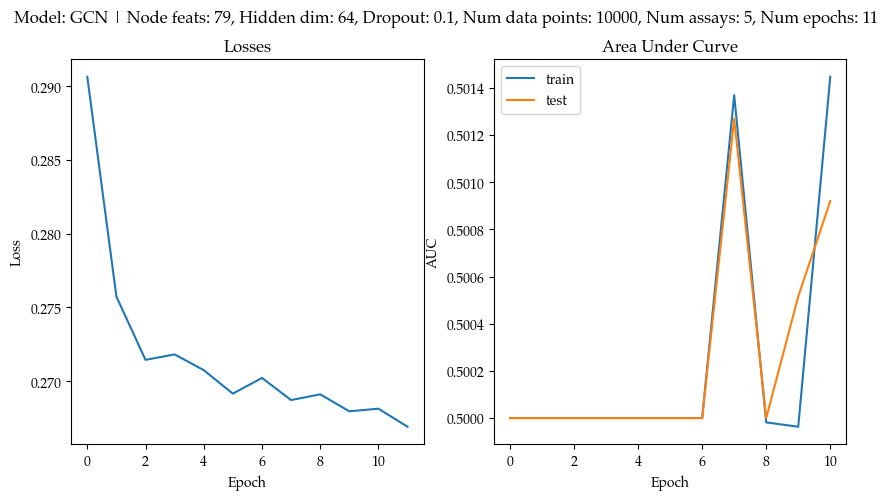

In [227]:
exp.analyze()

In [ ]:
args['model'] = 'GCN_FP'
exp = TrainManager(dataloader, args)
exp.train(epochs=200, log=True)

Model is on device: cpu
Epoch: 0, Loss: 0.2586, Train AUC: 0.5583, Test AUC: 0.5108
                        Train F1: 0.1482, Test F1: 0.0570
Epoch: 10, Loss: 0.1120, Train AUC: 0.8129, Test AUC: 0.5398
                        Train F1: 0.6777, Test F1: 0.1321
Epoch: 20, Loss: 0.0815, Train AUC: 0.8451, Test AUC: 0.5312
                        Train F1: 0.7937, Test F1: 0.1295
Epoch: 30, Loss: 0.1298, Train AUC: 0.9106, Test AUC: 0.5315
                        Train F1: 0.8691, Test F1: 0.1379
Epoch: 40, Loss: 0.1892, Train AUC: 0.9632, Test AUC: 0.5471
                        Train F1: 0.8435, Test F1: 0.1666
Epoch: 50, Loss: 0.0667, Train AUC: 0.9060, Test AUC: 0.5316
                        Train F1: 0.8824, Test F1: 0.1300
Epoch: 60, Loss: 0.0599, Train AUC: 0.9235, Test AUC: 0.5292
                        Train F1: 0.8824, Test F1: 0.1381
Epoch: 70, Loss: 0.0588, Train AUC: 0.9119, Test AUC: 0.5245
                        Train F1: 0.8398, Test F1: 0.1270
Epoch: 80, Loss: 0.0415, 

In [ ]:
exp.analyze()

In [240]:
args['model'] = 'FP'
exp = TrainManager(dataloader, args)
exp.train(epochs=100, log=True)

Model is on device: cpu
Epoch: 0, Loss: 0.3149, Train AUC: 0.5116, Test AUC: 0.5109
                        Train F1: 0.0442, Test F1: 0.0421
Epoch: 10, Loss: 0.1916, Train AUC: 0.5280, Test AUC: 0.5233
                        Train F1: 0.0981, Test F1: 0.0833
Epoch: 20, Loss: 0.2032, Train AUC: 0.5564, Test AUC: 0.5452
                        Train F1: 0.1774, Test F1: 0.1464


KeyboardInterrupt: 

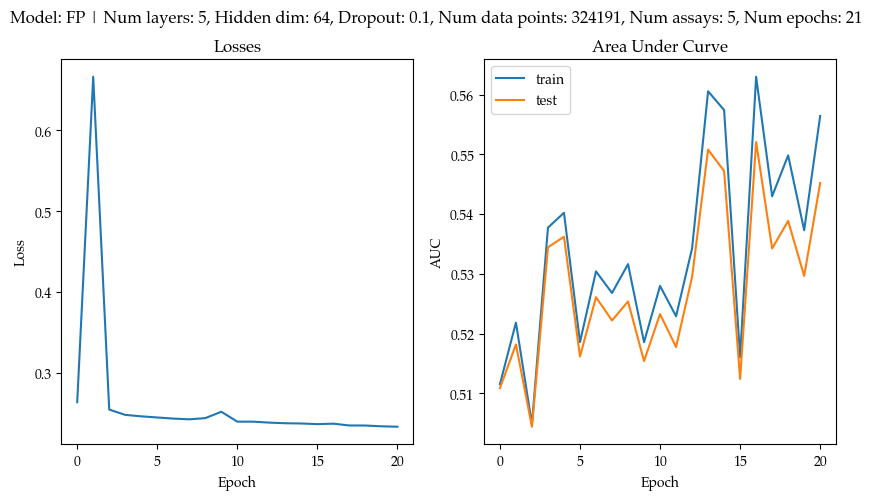

In [241]:
exp.analyze()

In [ ]:
args['model'] = 'GROVER'
exp = TrainManager(dataloader, args)
exp.train(epochs=200, log=True)

Model is on device: cuda:0
Epoch: 0, Loss: 0.4738, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 10, Loss: 0.4855, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 20, Loss: 0.5276, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 30, Loss: 0.5235, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 40, Loss: 0.5510, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 50, Loss: 0.6075, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 60, Loss: 0.4171, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 70, Loss: 0.5485, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 80, Loss: 0.4848, Train Acc: 0.7995, Test Acc: 0.8105
Epoch: 90, Loss: 0.5716, Train Acc: 0.7995, Test Acc: 0.8105


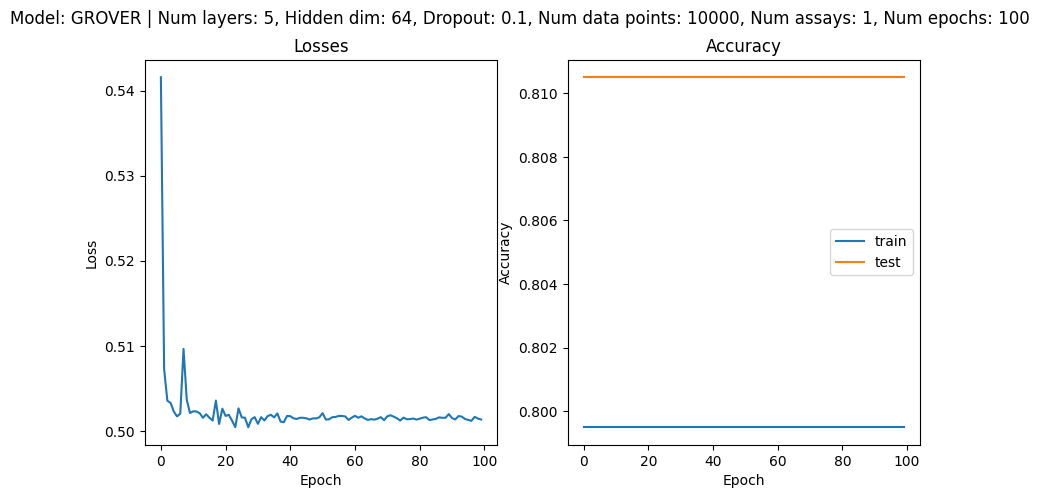

In [ ]:
exp.analyze()

### GROVER_FP

In [234]:
args['model'] = 'GROVER_FP'
exp = TrainManager(dataloader, args)
exp.train(epochs=200, log=True)

Model is on device: cpu
Epoch: 0, Loss: 0.2124, Train AUC: 0.5015, Test AUC: 0.5015
                        Train F1: 0.0084, Test F1: 0.0134
Epoch: 10, Loss: 0.1875, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 20, Loss: 0.2548, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 30, Loss: 0.3522, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 40, Loss: 0.1749, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 50, Loss: 0.3244, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 60, Loss: 0.2458, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 70, Loss: 0.3236, Train AUC: 0.5000, Test AUC: 0.5000
                        Train F1: 0.0000, Test F1: 0.0000
Epoch: 80, Loss: 0.2827, 

KeyboardInterrupt: 

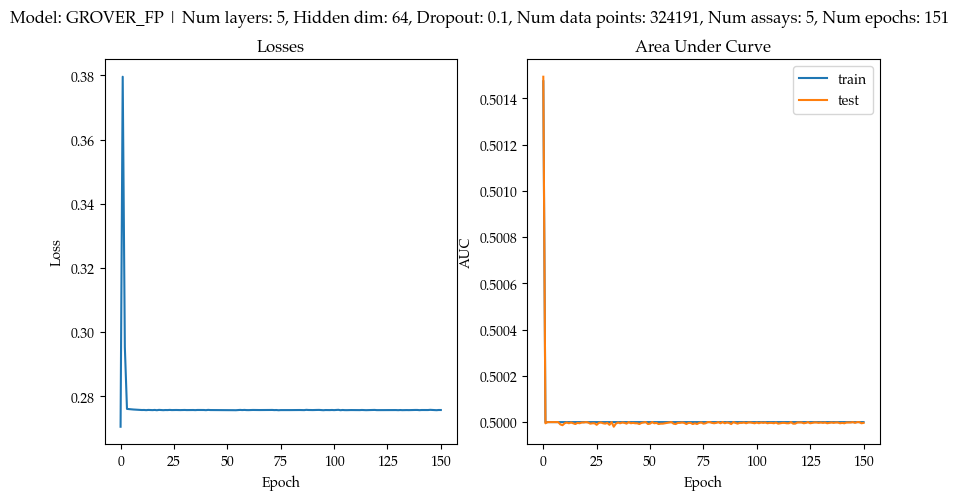

In [235]:
exp.analyze()

In [ ]:
args['model'] = 'GROVER_FP'
exp = TrainManager(dataloader, args)
exp.train(epochs=100, log=True)

Model is on device: cuda:0
Epoch: 0, Loss: 0.4337, Train Acc: 0.8022, Test Acc: 0.8020
Epoch: 10, Loss: 0.4334, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 20, Loss: 0.4617, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 30, Loss: 0.5262, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 40, Loss: 0.3913, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 50, Loss: 0.5047, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 60, Loss: 0.4828, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 70, Loss: 0.3990, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 80, Loss: 0.3902, Train Acc: 0.8023, Test Acc: 0.8020
Epoch: 90, Loss: 0.3735, Train Acc: 0.8023, Test Acc: 0.8020


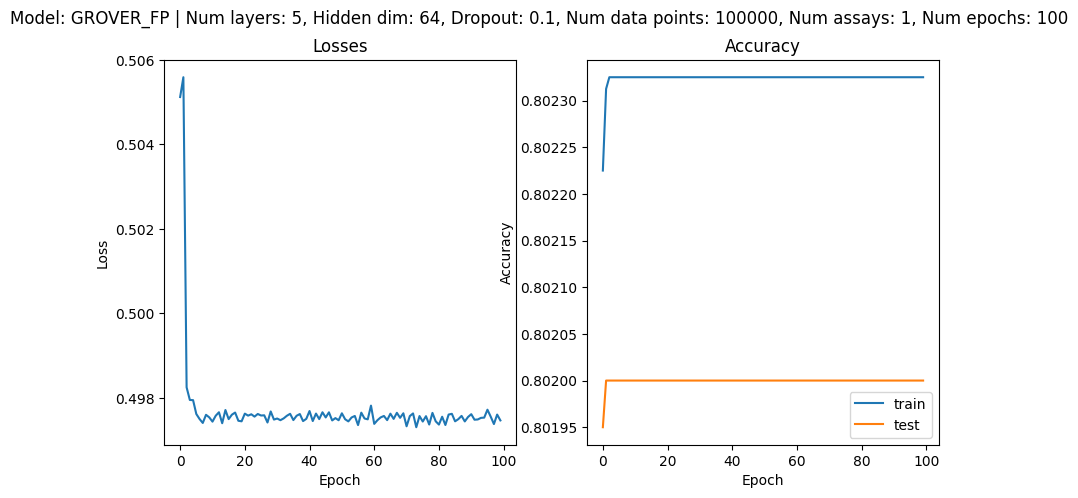

In [ ]:
exp.analyze()